## Set up

In [1]:
import os
import torch
import torchvision
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from torchvision.models import feature_extraction 

from src.dsprites import data, plot_util, utils, models
import importlib
importlib.reload(data)
importlib.reload(plot_util)
importlib.reload(utils)
importlib.reload(models)

<module 'src.dsprites.models' from '/home/laura/MID-level-activations/src/dsprites/models.py'>

In [2]:
import logging
logging.getLogger('matplotlib.font_manager').disabled = True

import ipywidgets as widgets  # Interactive display
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
# plt.style.use("https://raw.githubusercontent.com/NeuromatchAcademy/content-creation/main/nma.mplstyle")

plt.rc('axes', unicode_minus=False) # To ensure negatives render correctly with xkcd style
import warnings
warnings.filterwarnings("ignore")

In [3]:
checkpoint_dir = f'{os.path.join(os.path.dirname(os.getcwd()))}/checkpoints/dsprites'
results_dir = f'{os.path.join(os.path.dirname(os.getcwd()))}/results'

if not os.path.exists(checkpoint_dir):
    os.makedirs(checkpoint_dir)

if not os.path.exists(results_dir):
    os.makedirs(results_dir)

In [4]:
# Set global variables
seed = 4
utils.set_seed(seed=seed)
device = utils.set_device()

dropout_level=0.2 # 0
dropout=True

Random seed 4 has been set.
cuda device is enabled.


Mote: Remove `%%capture` at the start of a cell to plot figures. 

## Load data

In [5]:
dSprites = data.dSpritesDataset(
    os.path.join(os.environ.get("LIB_DATA", "."), "dsprites", "dsprites_ndarray_co1sh3sc6or40x32y32_64x64.npz")
    )

In [6]:
utils.set_seed(seed)

dSprites_torchdataset = data.dSpritesTorchDataset(
    dSprites,
    target_latent="shape"
    )

Random seed 4 has been set.


In [7]:
train_sampler_full, test_sampler_full, _, _ = data.train_test_split_idx(
    dSprites_torchdataset,
    fraction_train=0.8,  # 80:20 data split
    randst=seed, 
    num_samples=20000 # added this functionality
    )

print(f"Dataset size: {len(train_sampler_full)} training, "
      f"{len(test_sampler_full)} test images")

Dataset size: 16000 training, 4000 test images


## Train and load models

Train model no bias

In [8]:
def train_supervised_encoder(encoder, dataset, train_sampler, test_sampler, 
                             num_epochs=10, batch_size=1000, freeze_features=False, 
                             subset_seed=None, use_cuda=True,
                             progress_bar=True, verbose=False, seed=0, 
                             dropout=dropout, dropout_level=dropout_level
                            ):
  
  utils.set_seed(seed)

  print("Training a supervised encoder and classifier...")
  classifier, loss_array, train_acc, test_acc = models.train_classifier(
      encoder=encoder,
      dataset=dataset,
      train_sampler=train_sampler,
      test_sampler=test_sampler,
      num_epochs=num_epochs,
      batch_size=batch_size,
      freeze_features=freeze_features,
      use_cuda=use_cuda,
      progress_bar=progress_bar,
      verbose=verbose, 
      dropout=dropout, dropout_level=dropout_level
      )

  return encoder, classifier, loss_array, train_acc, test_acc

Train supervised classifier no bias

In [9]:
num_epochs = 60 # 10 60??? 
batch_size=1000

if dropout:
    supervised_encoder_full_path = os.path.join(os.path.dirname(os.getcwd()),"checkpoints/dsprites", f"supervised_encoder_{num_epochs}_drop{dropout_level}_ep_bs{batch_size}_seed{seed}.pth")
else: 
    supervised_encoder_full_path = os.path.join(os.path.dirname(os.getcwd()),"checkpoints/dsprites", f"supervised_encoder_{num_epochs}ep_bs{batch_size}_seed{seed}.pth")
    
if not os.path.isfile(supervised_encoder_full_path): 
    print("Training Model")

    supervised_encoder_full=models.EncoderCore(dropout=dropout, dropout_level=dropout_level)
    
    supervised_encoder_full, supervised_classifier_full, _, _, _ = train_supervised_encoder(
        encoder=supervised_encoder_full, 
        dataset=dSprites_torchdataset, 
        train_sampler=train_sampler_full, 
        test_sampler=test_sampler_full, 
        num_epochs=num_epochs, 
        batch_size=batch_size, 
        verbose=True, 
        seed=seed,
        dropout=dropout, dropout_level=dropout_level
        )
    
    torch.save(supervised_encoder_full.state_dict(), supervised_encoder_full_path)


else: 
    print("Model already saved, just train classifier")
    supervised_encoder_full = models.EncoderCore(dropout=dropout, dropout_level=dropout_level)
    supervised_encoder_full.load_state_dict(torch.load(supervised_encoder_full_path))

    utils.set_seed(seed)

    _, supervised_classifier, _, _, _ = train_supervised_encoder(
        encoder=supervised_encoder_full, 
        dataset=dSprites_torchdataset, 
        train_sampler=train_sampler_full, 
        test_sampler=test_sampler_full, 
        num_epochs=num_epochs, 
        batch_size=batch_size, 
        freeze_features=True,
        verbose=True, 
        seed=seed,
        dropout=dropout, dropout_level=dropout_level
        )


supervised_encoder_full.to("cpu")
# supervised_c/lassifier.to("cpu")
torch.cuda.empty_cache()

Training Model
Random seed 4 has been set.
Training a supervised encoder and classifier...
device: cuda


  0%|          | 0/60 [00:00<?, ?it/s]

Network performance after 60 encoder and classifier training epochs (chance: 33.33%):
    Training accuracy: 100.00%
    Testing accuracy: 99.42%


Look at RSM - This shows the model trained on unbiased data has similar representations for shapes of the same class and dissimilar for shapes from different classes (as expected as the model has almost 100% accuracy on the train and test set as shown below.). 

In [10]:
%%capture

sorting_latent = "shape"
print("Plotting RSMs...")
_ = models.plot_model_RSMs(
    encoders=[supervised_encoder_full],
    dataset=dSprites_torchdataset,
    sampler=test_sampler_full, 
    titles=["Supervised network encoder RSM"], 
    sorting_latent=sorting_latent,
    )

Plot performance for unbiased model

In [11]:
%%capture

importlib.reload(models)

utils.set_seed(seed)

classifiers_full_li, train_accs_full, test_accs_full, _ = models.train_encoder_clfs_by_prop_biases( 
    encoders=[[supervised_encoder_full]],
    dataset=dSprites_torchdataset,
    train_samplers=[train_sampler_full],
    test_samplers=[test_sampler_full],
    num_epochs=[8], 
    subset_seed=seed,
    encoder_labels=["supervised"],
    title="Performance of classifiers",
    verbose=True, 
    dropout=dropout, dropout_level=dropout_level
    )

## Introducing bias

Create completely biased (1.0 bias level) and control (0.0 bias level) samplers and datasets

In [12]:
utils.set_seed(seed)

bias_type = "shape_posX_spaced" # name of this bias

# initialize a biased training sampler and an unbiased test sampler
train_sampler_all_biased, test_sampler_all_biased, _, _ = data.train_test_split_idx(
    dSprites_torchdataset,
    fraction_train=0.95, # 95:5 split to partially compensate for loss of training examples due to bias
    randst=seed,
    train_pos_bias=bias_type, #########
    num_samples=20000
    )

# initialize a control, unbiased training sampler and an unbiased test sampler
train_sampler_bias_control, test_sampler_bias_control, _, _ = data.train_test_split_idx(
    dSprites_torchdataset,
    fraction_train=0.95,
    randst=seed,
    train_pos_bias=bias_type, #########
    control = True, 
    num_samples=20000
    )



Random seed 4 has been set.


Train models on them

In [13]:
num_epochs=80
batch_size=1000

if dropout: 
    supervised_encoder_bias_control_path = os.path.join(os.path.dirname(os.getcwd()),"checkpoints/dsprites", f"supervised_encoder_0.0_posX_bias_{num_epochs}ep_drop{dropout_level}_bs{batch_size}_seed{seed}.pth")
else: 
    supervised_encoder_bias_control_path = os.path.join(os.path.dirname(os.getcwd()),"checkpoints/dsprites", f"supervised_encoder_0.0_posX_bias_{num_epochs}ep_bs{batch_size}_seed{seed}.pth")
    
if not os.path.isfile(supervised_encoder_bias_control_path): 
    print("Training Model")

    utils.set_seed(seed)

    supervised_encoder_bias_control=models.EncoderCore(dropout=dropout, dropout_level=dropout_level)
    
    supervised_encoder_bias_control, _, _, _, _ = train_supervised_encoder(
        encoder=supervised_encoder_bias_control,
        dataset=dSprites_torchdataset,
        train_sampler=train_sampler_bias_control,
        test_sampler=test_sampler_bias_control, 
        num_epochs=num_epochs,
        batch_size=batch_size,  
        verbose=True, 
        seed=seed, 
        dropout=dropout, dropout_level=dropout_level
        )

    torch.save(supervised_encoder_bias_control.state_dict(), supervised_encoder_bias_control_path)

else: 
    print("bias control model already saved")
    supervised_encoder_bias_control = models.EncoderCore(dropout=dropout, dropout_level=dropout_level)
    supervised_encoder_bias_control.load_state_dict(torch.load(supervised_encoder_bias_control_path))



Training Model
Random seed 4 has been set.
Random seed 4 has been set.
Training a supervised encoder and classifier...
device: cuda


  0%|          | 0/80 [00:00<?, ?it/s]

Network performance after 80 encoder and classifier training epochs (chance: 33.33%):
    Training accuracy: 98.23%
    Testing accuracy: 78.20%


In [14]:
num_epochs=80
batch_size=1000
if dropout: 
    supervised_encoder_all_bias_path = os.path.join(os.path.dirname(os.getcwd()),"checkpoints/dsprites", f"supervised_encoder_1.0_posX_bias_{num_epochs}ep_drop{dropout_level}_bs{batch_size}_seed{seed}.pth")
else: 
    supervised_encoder_all_bias_path = os.path.join(os.path.dirname(os.getcwd()),"checkpoints/dsprites", f"supervised_encoder_1.0_posX_bias_{num_epochs}ep_bs{batch_size}_seed{seed}.pth")
    
if not os.path.isfile(supervised_encoder_all_bias_path): 
    print("Training Model")

    utils.set_seed(seed)

    supervised_encoder_all_bias=models.EncoderCore(dropout=dropout, dropout_level=dropout_level)
    
    supervised_encoder_all_bias, _, _, _, _ = train_supervised_encoder(
        encoder=supervised_encoder_all_bias,
        dataset=dSprites_torchdataset,
        train_sampler=train_sampler_all_biased,
        test_sampler=test_sampler_all_biased, 
        num_epochs=num_epochs,
        batch_size=batch_size,  
        verbose=True, 
        seed=seed,
        dropout=dropout, dropout_level=dropout_level
        )

    torch.save(supervised_encoder_all_bias.state_dict(), supervised_encoder_all_bias_path)

else: 
    print("bias model already saved")
    supervised_encoder_all_bias = models.EncoderCore(dropout=dropout, dropout_level=dropout_level)
    supervised_encoder_all_bias.load_state_dict(torch.load(supervised_encoder_all_bias_path))


Training Model
Random seed 4 has been set.
Random seed 4 has been set.
Training a supervised encoder and classifier...
device: cuda


  0%|          | 0/80 [00:00<?, ?it/s]

Network performance after 80 encoder and classifier training epochs (chance: 33.33%):
    Training accuracy: 100.00%
    Testing accuracy: 33.70%


Create samplers and datasets for different levels of bias and train models on them:

In [15]:
fraction_pos_bias_li = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]

for fraction_pos_bias in fraction_pos_bias_li:
    # initialize a proportion biased training sampler and an unbiased test sampler
    train_sampler_prop_biased, test_sampler_prop_biased, _, _ = data.train_test_split_idx(
        dSprites_torchdataset,
        fraction_train=0.95, # 95:5 split to partially compensate for loss of training examples due to bias
        randst=seed,
        train_pos_bias=bias_type,
        fraction_pos_bias = fraction_pos_bias, 
        num_samples=20000
        )
    
    print(f"Prop biased dataset: {len(train_sampler_prop_biased)} training, "
          f"{len(test_sampler_prop_biased)} test images")

    # print(f"Plotting first 20 images from the {fraction_pos_bias} biased training dataset.\n")
    # dSprites.show_images(indices=train_sampler_prop_biased.indices[:20], annotations="posX_quadrants")
    
    # supervised
    num_epochs=80
    batch_size=1000

    if dropout: 
        supervised_encoder_prop_bias_path = os.path.join(os.path.dirname(os.getcwd()),"checkpoints/dsprites", f"supervised_encoder_{fraction_pos_bias}_posX_bias_{num_epochs}ep_drop{dropout_level}_bs{batch_size}_seed{seed}.pth")
    else: 
        supervised_encoder_prop_bias_path = os.path.join(os.path.dirname(os.getcwd()),"checkpoints/dsprites", f"supervised_encoder_{fraction_pos_bias}_posX_bias_{num_epochs}ep_bs{batch_size}_seed{seed}.pth")
        
    if not os.path.isfile(supervised_encoder_prop_bias_path): 
        print("Training Model")
    
        utils.set_seed(seed)
    
        supervised_encoder_prop_bias=models.EncoderCore(dropout=dropout, dropout_level=dropout_level)
        
        supervised_encoder_prop_bias, _, _, _, _ = train_supervised_encoder(
            encoder=supervised_encoder_prop_bias,
            dataset=dSprites_torchdataset,
            train_sampler=train_sampler_prop_biased,
            test_sampler=test_sampler_prop_biased, 
            num_epochs=num_epochs,
            batch_size=batch_size,  
            verbose=True, 
            seed=seed,
            dropout=dropout, dropout_level=dropout_level
            )
    
        torch.save(supervised_encoder_prop_bias.state_dict(), supervised_encoder_prop_bias_path)
    
    else: 
        print("bias model already saved")
        supervised_encoder_prop_bias = models.EncoderCore(dropout=dropout, dropout_level=dropout_level)
        supervised_encoder_prop_bias.load_state_dict(torch.load(supervised_encoder_prop_bias_path))


Prop biased dataset: 6266 training, 1000 test images
Training Model
Random seed 4 has been set.
Random seed 4 has been set.
Training a supervised encoder and classifier...
device: cuda


  0%|          | 0/80 [00:00<?, ?it/s]

Network performance after 80 encoder and classifier training epochs (chance: 33.33%):
    Training accuracy: 87.98%
    Testing accuracy: 69.80%
Prop biased dataset: 7050 training, 1000 test images
Training Model
Random seed 4 has been set.
Random seed 4 has been set.
Training a supervised encoder and classifier...
device: cuda


  0%|          | 0/80 [00:00<?, ?it/s]

Network performance after 80 encoder and classifier training epochs (chance: 33.33%):
    Training accuracy: 89.21%
    Testing accuracy: 75.80%
Prop biased dataset: 8057 training, 1000 test images
Training Model
Random seed 4 has been set.
Random seed 4 has been set.
Training a supervised encoder and classifier...
device: cuda


  0%|          | 0/80 [00:00<?, ?it/s]

Network performance after 80 encoder and classifier training epochs (chance: 33.33%):
    Training accuracy: 84.25%
    Testing accuracy: 70.50%
Prop biased dataset: 9400 training, 1000 test images
Training Model
Random seed 4 has been set.
Random seed 4 has been set.
Training a supervised encoder and classifier...
device: cuda


  0%|          | 0/80 [00:00<?, ?it/s]

Network performance after 80 encoder and classifier training epochs (chance: 33.33%):
    Training accuracy: 99.38%
    Testing accuracy: 87.30%
Prop biased dataset: 11280 training, 1000 test images
Training Model
Random seed 4 has been set.
Random seed 4 has been set.
Training a supervised encoder and classifier...
device: cuda


  0%|          | 0/80 [00:00<?, ?it/s]

Network performance after 80 encoder and classifier training epochs (chance: 33.33%):
    Training accuracy: 99.78%
    Testing accuracy: 91.80%
Prop biased dataset: 9400 training, 1000 test images
Training Model
Random seed 4 has been set.
Random seed 4 has been set.
Training a supervised encoder and classifier...
device: cuda


  0%|          | 0/80 [00:00<?, ?it/s]

Network performance after 80 encoder and classifier training epochs (chance: 33.33%):
    Training accuracy: 99.90%
    Testing accuracy: 88.00%
Prop biased dataset: 8057 training, 1000 test images
Training Model
Random seed 4 has been set.
Random seed 4 has been set.
Training a supervised encoder and classifier...
device: cuda


  0%|          | 0/80 [00:00<?, ?it/s]

Network performance after 80 encoder and classifier training epochs (chance: 33.33%):
    Training accuracy: 96.61%
    Testing accuracy: 73.50%
Prop biased dataset: 7049 training, 1000 test images
Training Model
Random seed 4 has been set.
Random seed 4 has been set.
Training a supervised encoder and classifier...
device: cuda


  0%|          | 0/80 [00:00<?, ?it/s]

Network performance after 80 encoder and classifier training epochs (chance: 33.33%):
    Training accuracy: 97.16%
    Testing accuracy: 63.20%
Prop biased dataset: 6266 training, 1000 test images
Training Model
Random seed 4 has been set.
Random seed 4 has been set.
Training a supervised encoder and classifier...
device: cuda


  0%|          | 0/80 [00:00<?, ?it/s]

Network performance after 80 encoder and classifier training epochs (chance: 33.33%):
    Training accuracy: 99.95%
    Testing accuracy: 51.00%


Plotting RSMs for `shape` latent

In [16]:
%%capture

encoders_control = [supervised_encoder_bias_control]
all_fraction_pos_bias_li = [0.0]
all_fraction_pos_bias_li.extend(fraction_pos_bias_li)
all_fraction_pos_bias_li.append(1.0)

# train_sampler_bias_control, test_sampler_for_bias_control
encoders_prop_bias_li = [encoders_control]
all_train_sampler_prop_biased_li = []
all_test_sampler_prop_biased_li = []

all_train_sampler_prop_biased_li.append(train_sampler_bias_control)
all_test_sampler_prop_biased_li.append(test_sampler_bias_control) # test_sampler_for_bias_control

train_sampler_prop_biased_li = []
test_sampler_prop_biased_li = []

_ = models.plot_model_RSMs(
    encoders=encoders_control,
    dataset=dSprites_torchdataset,
    sampler=test_sampler_bias_control, # test_sampler_for_bias_control
    titles=["Bias control Supervised network encoder RSM"], 
    sorting_latent=sorting_latent,
    )

for fraction_pos_bias in fraction_pos_bias_li:
    # initialize a proportion biased training sampler and an unbiased test sampler
    train_sampler_prop_biased, test_sampler_prop_biased, _, _ = data.train_test_split_idx(
        dSprites_torchdataset,
        fraction_train=0.95, # 95:5 split to partially compensate for loss of training examples due to bias
        randst=seed,
        train_pos_bias=bias_type,
        fraction_pos_bias = fraction_pos_bias, 
        num_samples=20000
        )
    
    print(f"Prop biased dataset {fraction_pos_bias}: {len(train_sampler_prop_biased)} training, "
          f"{len(test_sampler_prop_biased)} test images")

    num_epochs=80
    batch_size=1000
    if dropout: 
        supervised_encoder_prop_bias_path = os.path.join(os.path.dirname(os.getcwd()),"checkpoints/dsprites", f"supervised_encoder_{fraction_pos_bias}_posX_bias_{num_epochs}ep_drop{dropout_level}_bs{batch_size}_seed{seed}.pth")
    else: 
        supervised_encoder_prop_bias_path = os.path.join(os.path.dirname(os.getcwd()),"checkpoints/dsprites", f"supervised_encoder_{fraction_pos_bias}_posX_bias_{num_epochs}ep_bs{batch_size}_seed{seed}.pth")

    supervised_encoder_prop_bias = models.EncoderCore(dropout=dropout, dropout_level=dropout_level)
    supervised_encoder_prop_bias.load_state_dict(torch.load(supervised_encoder_prop_bias_path))

    encoders_li = [supervised_encoder_prop_bias]
    encoders_prop_bias_li.append(encoders_li)
    test_sampler_prop_biased_li.append(test_sampler_prop_biased)
    train_sampler_prop_biased_li.append(train_sampler_prop_biased)
    all_test_sampler_prop_biased_li.append(test_sampler_prop_biased)
    all_train_sampler_prop_biased_li.append(train_sampler_prop_biased)

    sorting_latent = "shape" 
    _ = models.plot_model_RSMs(
        encoders=[supervised_encoder_prop_bias],
        dataset=dSprites_torchdataset,
        sampler=test_sampler_prop_biased, 
        titles=[f"{fraction_pos_bias} bias Supervised network encoder RSM"], 
        sorting_latent=sorting_latent,
        )

# all_train_sampler_prop_biased_li.extend(train_sampler_bias_control)
# all_test_sampler_prop_biased_li.extend(test_sampler_for_bias_control)

encoders_prop_bias = [supervised_encoder_all_bias]
encoders_prop_bias_li.append(encoders_prop_bias)
all_train_sampler_prop_biased_li.append(train_sampler_all_biased)
all_test_sampler_prop_biased_li.append(test_sampler_all_biased)
                            
_ = models.plot_model_RSMs(
    encoders=encoders_prop_bias,
    dataset=dSprites_torchdataset,
    sampler=test_sampler_all_biased, 
    titles=["Bias Supervised network encoder RSM"], 
    sorting_latent=sorting_latent,
    )


Plotting RSMs for `posX` latent

In [17]:
%%capture

encoders_control = [supervised_encoder_bias_control]
all_fraction_pos_bias_li = [0.0]
all_fraction_pos_bias_li.extend(fraction_pos_bias_li)
all_fraction_pos_bias_li.append(1.0)

# train_sampler_bias_control, test_sampler_for_bias_control
encoders_prop_bias_li = [encoders_control]
all_train_sampler_prop_biased_li = []
all_test_sampler_prop_biased_li = []

all_train_sampler_prop_biased_li.append(train_sampler_bias_control)
all_test_sampler_prop_biased_li.append(test_sampler_bias_control) # test_sampler_for_bias_control

train_sampler_prop_biased_li = []
test_sampler_prop_biased_li = []
sorting_latent = "posX"
_ = models.plot_model_RSMs(
    encoders=encoders_control,
    dataset=dSprites_torchdataset,
    sampler=test_sampler_bias_control, # test_sampler_for_bias_control
    titles=["Bias control Supervised network encoder RSM"], 
    sorting_latent=sorting_latent,
    )

for fraction_pos_bias in fraction_pos_bias_li:
    # initialize a proportion biased training sampler and an unbiased test sampler
    train_sampler_prop_biased, test_sampler_prop_biased, _, _ = data.train_test_split_idx(
        dSprites_torchdataset,
        fraction_train=0.95, # 95:5 split to partially compensate for loss of training examples due to bias
        randst=seed,
        train_pos_bias=bias_type,
        fraction_pos_bias = fraction_pos_bias, 
        num_samples=20000
        )
    
    print(f"Prop biased dataset {fraction_pos_bias}: {len(train_sampler_prop_biased)} training, "
          f"{len(test_sampler_prop_biased)} test images")

    num_epochs=80
    batch_size=1000
    if dropout: 
        supervised_encoder_prop_bias_path = os.path.join(os.path.dirname(os.getcwd()),"checkpoints/dsprites", f"supervised_encoder_{fraction_pos_bias}_posX_bias_{num_epochs}ep_drop{dropout_level}_bs{batch_size}_seed{seed}.pth")
    else: 
        supervised_encoder_prop_bias_path = os.path.join(os.path.dirname(os.getcwd()),"checkpoints/dsprites", f"supervised_encoder_{fraction_pos_bias}_posX_bias_{num_epochs}ep_bs{batch_size}_seed{seed}.pth")
    
    supervised_encoder_prop_bias = models.EncoderCore(dropout=dropout, dropout_level=dropout_level)
    supervised_encoder_prop_bias.load_state_dict(torch.load(supervised_encoder_prop_bias_path))
   
    encoders_li = [supervised_encoder_prop_bias]
    encoders_prop_bias_li.append(encoders_li)
    test_sampler_prop_biased_li.append(test_sampler_prop_biased)
    train_sampler_prop_biased_li.append(train_sampler_prop_biased)
    all_test_sampler_prop_biased_li.append(test_sampler_prop_biased)
    all_train_sampler_prop_biased_li.append(train_sampler_prop_biased)

    sorting_latent = "posX" # DEMO: Try sorting by different latent dimensions
    _ = models.plot_model_RSMs(
        encoders=[supervised_encoder_prop_bias],
        dataset=dSprites_torchdataset,
        sampler=test_sampler_prop_biased, 
        titles=[f"{fraction_pos_bias} bias Supervised network encoder RSM"], 
        sorting_latent=sorting_latent,
        )

# all_train_sampler_prop_biased_li.extend(train_sampler_bias_control)
# all_test_sampler_prop_biased_li.extend(test_sampler_for_bias_control)

encoders_prop_bias = [supervised_encoder_all_bias]
encoders_prop_bias_li.append(encoders_prop_bias)
all_train_sampler_prop_biased_li.append(train_sampler_all_biased)
all_test_sampler_prop_biased_li.append(test_sampler_all_biased)

                            
_ = models.plot_model_RSMs(
    encoders=encoders_prop_bias,
    dataset=dSprites_torchdataset,
    sampler=test_sampler_all_biased, 
    titles=["Bias Supervised network encoder RSM"], 
    sorting_latent=sorting_latent,
    )


Plot the test and train accuracies for each bias level for the selected seed. 

Random seed 4 has been set.
0.0% purposely biased


0it [00:00, ?it/s]

Supervised encoder: training classifiers...
device: cuda
0.1% purposely biased


0it [00:00, ?it/s]

Supervised encoder: training classifiers...
device: cuda
0.2% purposely biased


0it [00:00, ?it/s]

Supervised encoder: training classifiers...
device: cuda
0.3% purposely biased


0it [00:00, ?it/s]

Supervised encoder: training classifiers...
device: cuda
0.4% purposely biased


0it [00:00, ?it/s]

Supervised encoder: training classifiers...
device: cuda
0.5% purposely biased


0it [00:00, ?it/s]

Supervised encoder: training classifiers...
device: cuda
0.6% purposely biased


0it [00:00, ?it/s]

Supervised encoder: training classifiers...
device: cuda
0.7% purposely biased


0it [00:00, ?it/s]

Supervised encoder: training classifiers...
device: cuda
0.8% purposely biased


0it [00:00, ?it/s]

Supervised encoder: training classifiers...
device: cuda
0.9% purposely biased


0it [00:00, ?it/s]

Supervised encoder: training classifiers...
device: cuda
1.0% purposely biased


0it [00:00, ?it/s]

Supervised encoder: training classifiers...
device: cuda


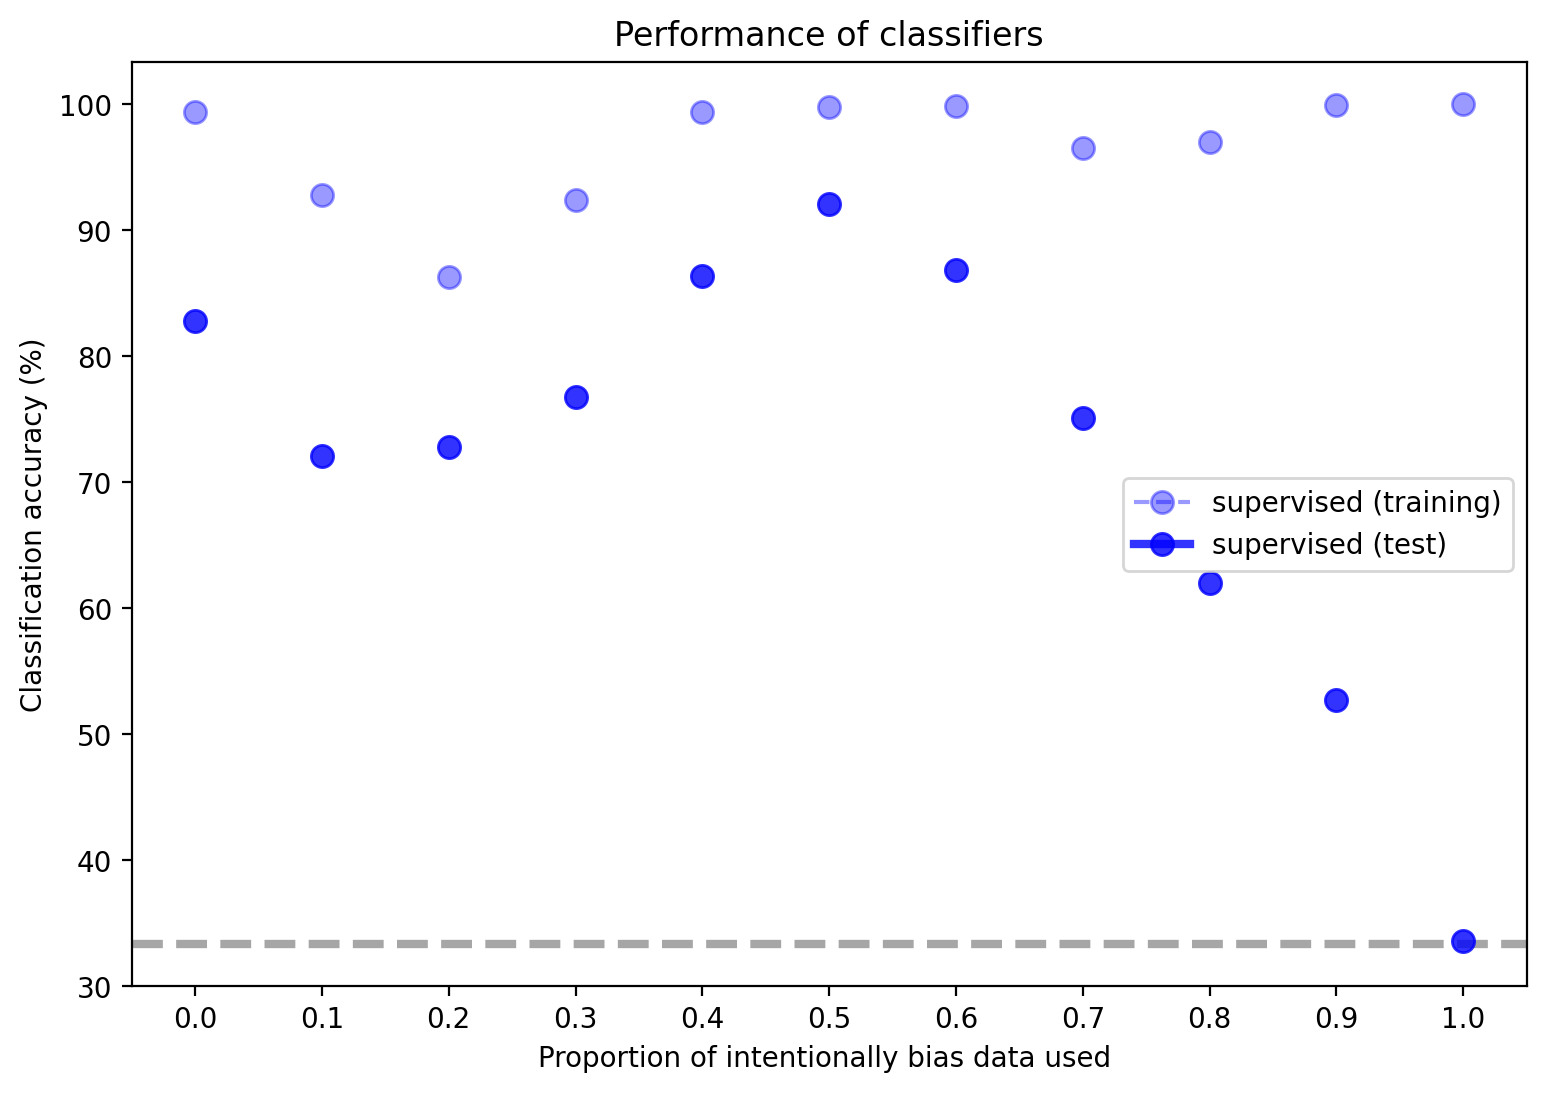

In [18]:
# %%capture

utils.set_seed(seed)

classifiers_prop_bias_li, train_accs_prop_bias, test_accs_prop_bias, _ = models.train_encoder_clfs_by_prop_biases( 
    encoders=encoders_prop_bias_li,
    dataset=dSprites_torchdataset,
    train_samplers=all_train_sampler_prop_biased_li,
    test_samplers=all_test_sampler_prop_biased_li,
    prop_biases=all_fraction_pos_bias_li,
    num_epochs=[8], 
    subset_seed=seed,
    encoder_labels=["supervised"],
    title="Performance of classifiers",
    verbose=True,
    dropout=dropout, dropout_level=dropout_level
    )

In [19]:
# need to transpose lists to plot with lines
supervised = []
for i in range(len(train_accs_prop_bias)): 
    supervised.append(train_accs_prop_bias[i][0])
train_accs_prop_bias = [supervised]

supervised = []
for i in range(len(test_accs_prop_bias)): 
    supervised.append(test_accs_prop_bias[i][0])
test_accs_prop_bias = [supervised]

Text(0.5, 1.0, 'Performance of classifiers trained\nwith different network encoders')

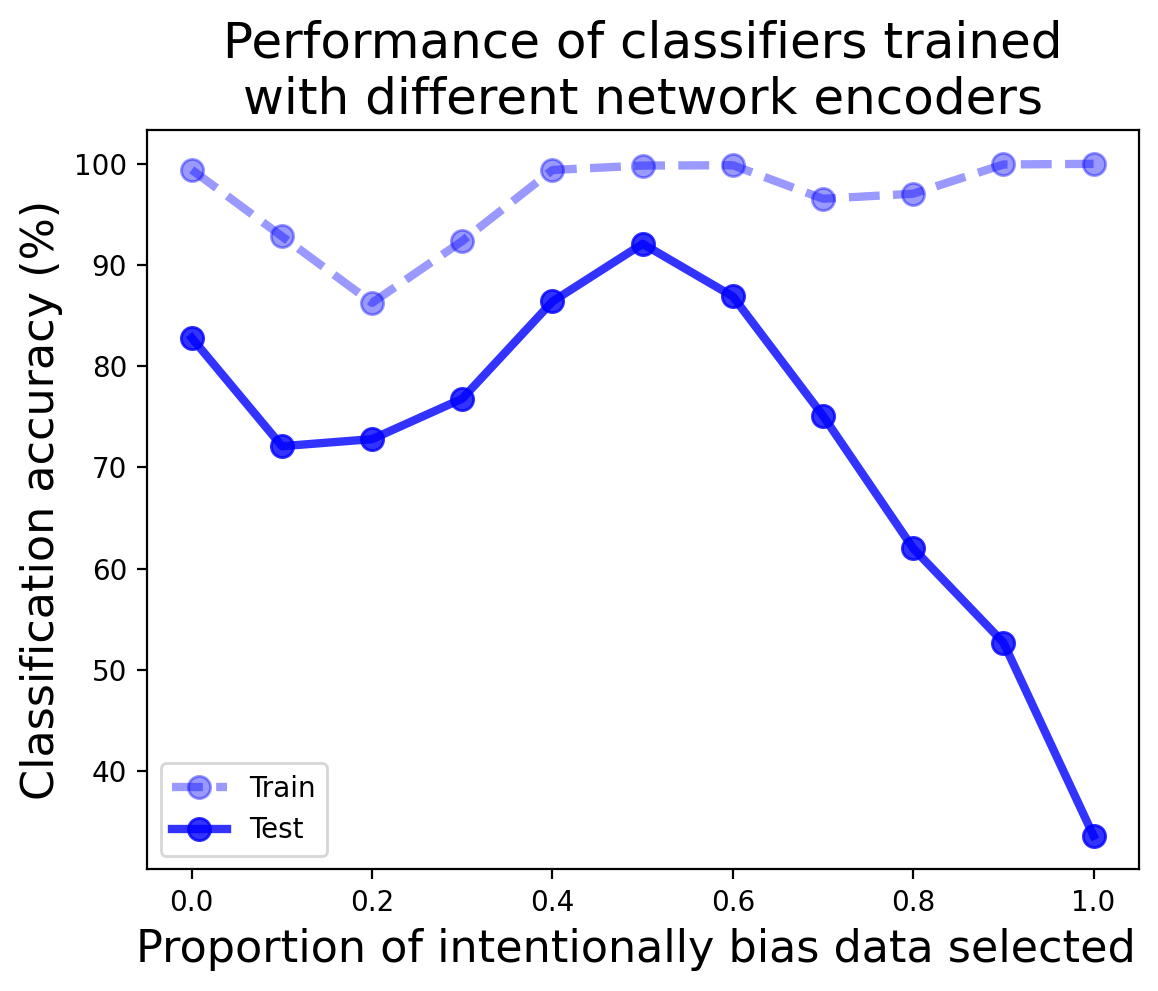

In [20]:
# plot with lines for clarity
labels=["Train", "Test"]
colors = ["blue", "brown", "green", "red", "purple", "black", "orange"] 
markers = ["o", "^", "P", "d", "X", "p", "*"] 

plt.plot(all_fraction_pos_bias_li, train_accs_prop_bias[0], ls="dashed", 
         lw=3, label=labels[0], color=colors[0], marker=markers[0], markersize=8, alpha=0.4)

plt.plot(all_fraction_pos_bias_li, test_accs_prop_bias[0], 
         lw=3, label=labels[1], color=colors[0], marker=markers[0], markersize=8, alpha=0.8)
    
plt.legend(labels)
plt.xlabel("Proportion of intentionally bias data selected ", fontsize=16) #(log scale)")
plt.ylabel("Classification accuracy (%)", fontsize=16)
plt.title("Performance of classifiers trained\nwith different network encoders", fontsize=18)

## Confidence intervals for plot - run the above script for some seeds

In [21]:
import json
CI_file = os.path.join(os.path.dirname(os.getcwd()),f'results/result_for_CI_supervised_encoder_{num_epochs}_drop{dropout_level}_ep_bs{batch_size}.json')

if not os.path.exists(CI_file):
    with open(CI_file, 'w') as file:
        json.dump({}, file)

with open(CI_file) as json_file:
    json_decoded = json.load(json_file)

train_key_to_add = f'train_seed_{seed}'
test_key_to_add = f'test_seed_{seed}'

json_decoded[train_key_to_add] = train_accs_prop_bias
json_decoded[test_key_to_add] = test_accs_prop_bias

with open(CI_file, 'w') as json_file:
    json.dump(json_decoded, json_file, indent=4)

In [22]:
with open(CI_file) as json_file:
    json_decoded = json.load(json_file)

num_seeds = 3

seed_train_accs_prop_bias = []
seed_test_accs_prop_bias = []
for seed_id in range(num_seeds):
    seed_train_accs_prop_bias.append(json_decoded[f'train_seed_{seed_id}'])
    seed_test_accs_prop_bias.append(json_decoded[f'test_seed_{seed_id}'])

seed_test_accs_prop_bias
[[[82.7, 85.1, 87.2, 87.4, 89.3, 89.0, 82.1, 71.0, 59.9, 50.8, 35.3]],
 [[86.6, 85.5, 88.9, 88.5, 88.3, 89.7, 82.1, 73.8, 63.6, 46.2, 34.9]],
 [[81.8, 80.2, 84.5, 86.5, 87.9, 83.8, 79.3, 70.0, 58.1, 43.5, 32.7]],
 [[81.5, 82.5, 85.2, 86.4, 86.1, 86.8, 79.0, 73.6, 64.5, 49.4, 33.5]],
 [[80.9, 83.0, 86.3, 86.5, 88.4, 90.3, 85.4, 79.3, 68.8, 45.4, 33.5]]]

seed_train_accs_prop_bias
[[[100.0,
   100.0,
   100.0,
   100.0,
   100.0,
   100.0,
   100.0,
   100.0,
   100.0,
   99.96901146575767,
   100.0]],
 [[100.0,
   100.0,
   100.0,
   100.0,
   100.0,
   100.0,
   100.0,
   100.0,
   99.98607630186578,
   99.984335839599,
   100.0]],
 [[100.0,
   100.0,
   100.0,
...
   100.0,
   100.0,
   100.0,
   99.56910309607404,
   100.0]]]

len(seed_test_accs_prop_bias[0][0])
11



In [23]:
# calculate mean_seed_test_accs_prop_bias first
mean_seed_test_accs_prop_bias = [0] * len(seed_test_accs_prop_bias[0][0]) # 11, one for each bias
for list_id in range(len(seed_test_accs_prop_bias)): # [0,5)
    for idx, bias_level in enumerate(seed_test_accs_prop_bias[list_id][0]): 
        mean_seed_test_accs_prop_bias[idx]+=bias_level

for bias_level in range(len(seed_test_accs_prop_bias[0][0])):
    mean_seed_test_accs_prop_bias[bias_level] = mean_seed_test_accs_prop_bias[bias_level] / len(seed_test_accs_prop_bias)
    
# now calculate var_seed_test_accs_prop_bias
var_seed_test_accs_prop_bias = [0] * len(seed_test_accs_prop_bias[0][0]) # 11, one for each bias
std_seed_test_accs_prop_bias = [0] * len(seed_test_accs_prop_bias[0][0]) # 11, one for each bias
ci95_seed_test_accs_prop_bias = [0] * len(seed_test_accs_prop_bias[0][0]) # 11, one for each bias
for list_id in range(len(seed_test_accs_prop_bias)): # [0,5)
    for idx, bias_level in enumerate(seed_test_accs_prop_bias[list_id][0]):
        var_seed_test_accs_prop_bias[idx]+=(bias_level-mean_seed_test_accs_prop_bias[idx])**2

for bias_level in range(len(seed_test_accs_prop_bias[0][0])):
    var_seed_test_accs_prop_bias[bias_level] = var_seed_test_accs_prop_bias[bias_level] / len(seed_test_accs_prop_bias)

for bias_level in range(len(seed_test_accs_prop_bias[0][0])):
    std_seed_test_accs_prop_bias[bias_level] = var_seed_test_accs_prop_bias[bias_level]**0.5

for bias_level in range(len(seed_test_accs_prop_bias[0][0])):
    ci95_seed_test_accs_prop_bias[bias_level] = 1.96 * std_seed_test_accs_prop_bias[bias_level] / np.sqrt(len(seed_test_accs_prop_bias)) # 1.96*std / 5
# ci = 1.96 * np.std(y)/np.sqrt(len(x))
    
    
mean_seed_test_accs_prop_bias # mean accuracy for each bias level
var_seed_test_accs_prop_bias
std_seed_test_accs_prop_bias
# ci95_seed_test_accs_prop_bias
# # 1.96/np.sqrt(5) = 0.8765386471799175

[2.3537204591879592,
 8.287473814270685,
 5.460362218347383,
 4.605069670120822,
 2.7932458220182155,
 1.4007934259633814,
 4.943233309844433,
 3.7709415269929605,
 5.68057117628931,
 3.137231617560652,
 1.0873004286866714]

In [24]:
# same for test (but constant 100 anyway)
mean_seed_train_accs_prop_bias = [0] * len(seed_train_accs_prop_bias[0][0])
for row in seed_train_accs_prop_bias: 
    # for element in row[0]: 
    for i in range(0,len(row[0])):
        mean_seed_train_accs_prop_bias[i] += row[0][i]

for i in range(len(mean_seed_train_accs_prop_bias)):
    mean_seed_train_accs_prop_bias[i] = mean_seed_train_accs_prop_bias[i]/5

mean_seed_test_accs_prop_bias = [0] * len(seed_test_accs_prop_bias[0][0])
# mean_seed_test_accs_prop_bias
for row in seed_test_accs_prop_bias: 
    # for element in row[0]: 
    for i in range(0,len(row[0])):
        mean_seed_test_accs_prop_bias[i] += row[0][i]

for i in range(len(mean_seed_test_accs_prop_bias)):
    mean_seed_test_accs_prop_bias[i] = mean_seed_test_accs_prop_bias[i]/5

In [25]:
# lower_seed_test_accs_prop_bias = 
lower_seed_test_accs_prop_bias = set(mean_seed_test_accs_prop_bias) - set(ci95_seed_test_accs_prop_bias)
# lower_seed_test_accs_prop_bias = set(mean_seed_test_accs_prop_bias) + set(ci95_seed_test_accs_prop_bias)
# lower_seed_test_accs_prop_bias

[a - b for a, b in zip(mean_seed_test_accs_prop_bias, ci95_seed_test_accs_prop_bias)]

[50.136514564209776,
 41.66184053436054,
 46.001018470593976,
 48.54887310118477,
 51.899144794580174,
 54.41485301534433,
 46.68620491907261,
 44.15277795281286,
 35.83182857634834,
 29.16988822293866,
 19.3096037374232]

Text(0.5, 1.0, 'Performance of classifiers trained\nwith different network encoders')

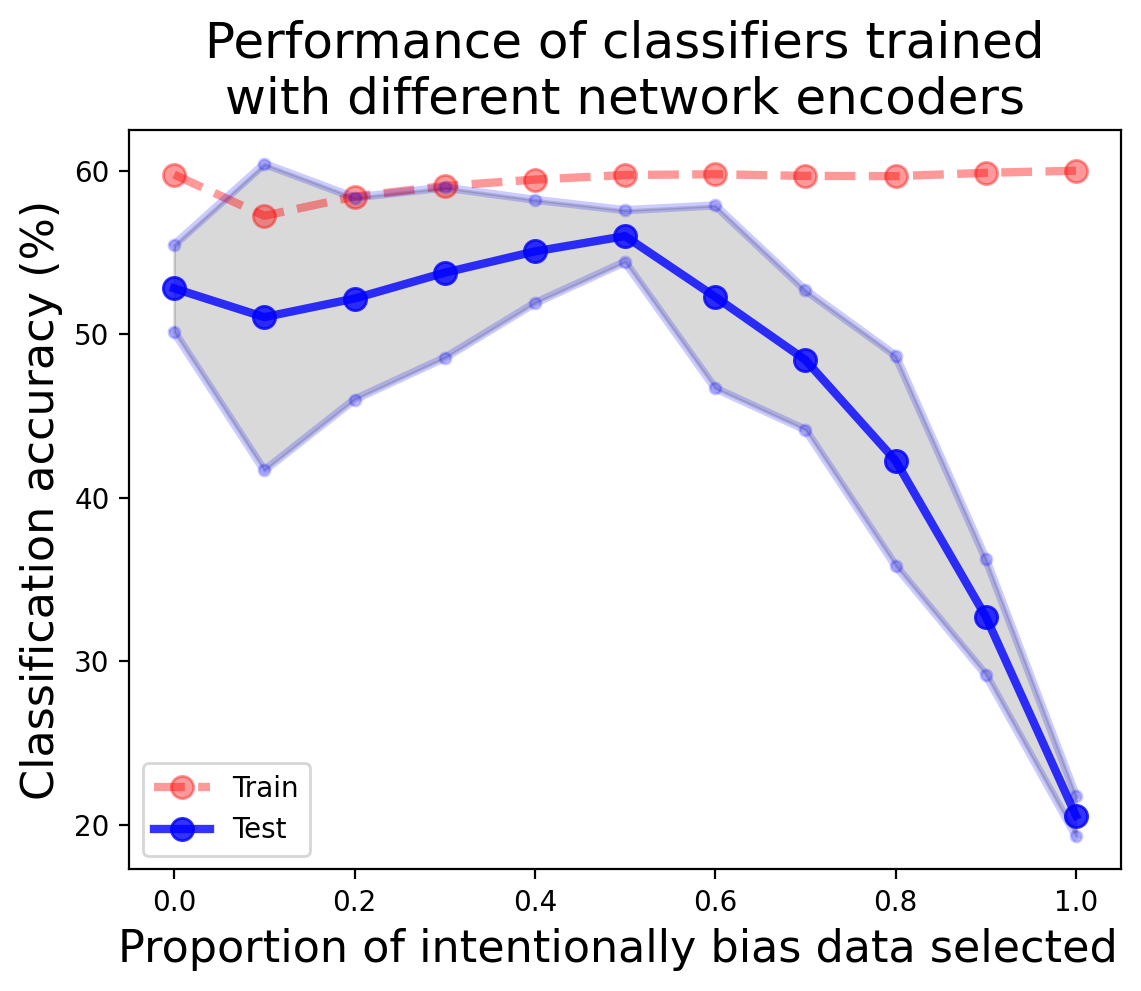

In [26]:
# plot with lines for clarity
labels=["Train", "Test"]
colors = ["blue", "brown", "green", "red", "purple", "black", "orange"] 
markers = ["o", "^", "P", "d", "X", "p", "*"] 

plt.plot(all_fraction_pos_bias_li, mean_seed_train_accs_prop_bias, ls="dashed", 
         lw=3, label=labels[0], color=colors[3], marker=markers[0], markersize=8, alpha=0.4)
plt.plot(all_fraction_pos_bias_li, mean_seed_test_accs_prop_bias, lw=3, label=labels[1], color=colors[0], marker=markers[0], markersize=8, alpha=0.8)

plt.plot(all_fraction_pos_bias_li, [a - b for a, b in zip(mean_seed_test_accs_prop_bias, ci95_seed_test_accs_prop_bias)], lw=3, label=labels[1], color=colors[0], marker=markers[0], markersize=4, alpha=0.2)
plt.plot(all_fraction_pos_bias_li, [a + b for a, b in zip(mean_seed_test_accs_prop_bias, ci95_seed_test_accs_prop_bias)], lw=3, label=labels[1], color=colors[0], marker=markers[0], markersize=4, alpha=0.2)

plt.fill_between(all_fraction_pos_bias_li, [a + b for a, b in zip(mean_seed_test_accs_prop_bias, ci95_seed_test_accs_prop_bias)], [a - b for a, b in zip(mean_seed_test_accs_prop_bias, ci95_seed_test_accs_prop_bias)], color="k", alpha=0.15)

# plt.fill_between(all_fraction_pos_bias_li, mean_seed_test_accs_prop_bias-ci95_seed_test_accs_prop_bias, mean_seed_test_accs_prop_bias+ci95_seed_test_accs_prop_bias,
#          lw=3, label=labels[1], color=colors[0], marker=markers[0], markersize=8, alpha=0.8)

plt.legend(labels)
plt.xlabel("Proportion of intentionally bias data selected ", fontsize=16) #(log scale)")
plt.ylabel("Classification accuracy (%)", fontsize=16)
plt.title("Performance of classifiers trained\nwith different network encoders", fontsize=18)